In [20]:
"""
Model Training for HCV Disease Prediction
==========================================
Training multiple classification algorithms to predict HCV disease stages
Using balanced accuracy as primary metric due to class imbalance
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, auc, balanced_accuracy_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("Libraries loaded successfully")

Libraries loaded successfully


In [21]:
# Load preprocessed data
data_dir = '../data/processed/'

X_train = pd.read_csv(f'{data_dir}X_train.csv')
X_val = pd.read_csv(f'{data_dir}X_val.csv')
X_test = pd.read_csv(f'{data_dir}X_test.csv')

y_train = pd.read_csv(f'{data_dir}y_train.csv')['Category']
y_val = pd.read_csv(f'{data_dir}y_val.csv')['Category']
y_test = pd.read_csv(f'{data_dir}y_test.csv')['Category']

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print(f"\nClass distribution in training (balanced with SMOTE):")
print(y_train.value_counts().sort_index())

Data shapes:
X_train: (1264, 22), y_train: (1264,)
X_val: (118, 22), y_val: (118,)
X_test: (118, 22), y_test: (118,)

Class distribution in training (balanced with SMOTE):
Category
0    316
1    316
2    316
3    316
Name: count, dtype: int64


In [22]:
class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
        self.best_score = 0

    def select_model(self, name, model):
        self.models[name] = model

    def train_model(self, name, X_train, y_train, X_val, y_val):
        """Train a single model and evaluate on validation set"""

        print(f"\nTraining {name}...")
        start_time = time.time()

        # Train
        model = self.models[name]
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        
        # BALANCED ACCURACY - PRIMARY METRIC
        train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
        val_balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted')
        
        # Calculate per-class recall for understanding
        cm = confusion_matrix(y_val, y_val_pred)
        per_class_recall = cm.diagonal() / cm.sum(axis=1)
        
        # Training time
        training_time = time.time() - start_time
        
        # Store results
        self.results[name] = {
            'model': model,
            'train_accuracy': train_acc,
            'train_balanced_accuracy': train_balanced_acc,
            'val_accuracy': val_acc,
            'val_balanced_accuracy': val_balanced_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'per_class_recall': per_class_recall,
            'training_time': training_time,
            'y_val_pred': y_val_pred,
            'confusion_matrix': cm
        }
        
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Training Balanced Accuracy: {train_balanced_acc:.4f}")
        print(f"  Validation Accuracy: {val_acc:.4f}")
        print(f"  Validation Balanced Accuracy: {val_balanced_acc:.4f}")
        print(f"  Validation F1-Score: {val_f1:.4f}")
        print(f"  Per-Class Recall: {per_class_recall.round(3)}")
        print(f"  Training Time: {training_time:.2f} seconds")
        
        # Update best model based on BALANCED ACCURACY
        if val_balanced_acc > self.best_score:
            self.best_score = val_balanced_acc
            self.best_model = name
            
        return model
    
    def train_all(self, X_train, y_train, X_val, y_val):
        """Train all models"""
        for name in self.models.keys():
            self.train_model(name, X_train, y_train, X_val, y_val)
        
        print(f"\nBest Model: {self.best_model} (Balanced Accuracy: {self.best_score:.4f})")
        
    def get_results_dataframe(self):
        """Return results as a sorted dataframe"""
        df = pd.DataFrame(self.results).T
        # Sort by balanced accuracy instead of F1
        df = df.sort_values('val_balanced_accuracy', ascending=False)
        return df[['train_accuracy', 'train_balanced_accuracy', 'val_accuracy', 
                   'val_balanced_accuracy', 'val_f1', 'val_precision', 'val_recall', 'training_time']]

In [23]:
# Initialize trainer and add models
trainer = ModelTrainer()

# Add models to compare
trainer.select_model('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))
trainer.select_model('Decision Tree', DecisionTreeClassifier(random_state=42))
trainer.select_model('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))
trainer.select_model('XGBoost', XGBClassifier(random_state=42, eval_metric='mlogloss'))
trainer.select_model('SVM', SVC(kernel='rbf', random_state=42))

print("Models initialized:")
for name in trainer.models.keys():
    print(f"  - {name}")


Models initialized:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost
  - SVM


In [24]:
# Training all models 

print("="*60)
print("TRAINING MODELS WITH BALANCED ACCURACY")
print("="*60)

trainer.train_all(X_train, y_train, X_val, y_val)

# Display results summary
print("\n" + "="*60)
print("RESULTS SUMMARY (Sorted by Balanced Accuracy)")
print("="*60)
results_df = trainer.get_results_dataframe()
print(results_df.round(4))

TRAINING MODELS WITH BALANCED ACCURACY

Training Logistic Regression...
  Training Accuracy: 0.9984
  Training Balanced Accuracy: 0.9984
  Validation Accuracy: 0.9237
  Validation Balanced Accuracy: 0.5452
  Validation F1-Score: 0.9291
  Per-Class Recall: [0.981 0.6   0.    0.6  ]
  Training Time: 0.17 seconds

Training Decision Tree...
  Training Accuracy: 1.0000
  Training Balanced Accuracy: 1.0000
  Validation Accuracy: 0.9492
  Validation Balanced Accuracy: 0.6476
  Validation F1-Score: 0.9413
  Per-Class Recall: [0.99 0.8  0.   0.8 ]
  Training Time: 0.07 seconds

Training Random Forest...
  Training Accuracy: 1.0000
  Training Balanced Accuracy: 1.0000
  Validation Accuracy: 0.9576
  Validation Balanced Accuracy: 0.6500
  Validation F1-Score: 0.9478
  Per-Class Recall: [1.  0.8 0.  0.8]
  Training Time: 1.04 seconds

Training XGBoost...
  Training Accuracy: 1.0000
  Training Balanced Accuracy: 1.0000
  Validation Accuracy: 0.9492
  Validation Balanced Accuracy: 0.6000
  Validatio

In [25]:
trainer.get_results_dataframe()

,train_accuracy,train_balanced_accuracy,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,training_time
Random Forest,1.0,1.0,0.957627,0.65,0.94776,0.939547,0.957627,1.042582
Decision Tree,1.0,1.0,0.949153,0.647619,0.94133,0.936441,0.949153,0.072325
XGBoost,1.0,1.0,0.949153,0.6,0.935579,0.924651,0.949153,0.81629
Logistic Regression,0.998418,0.998418,0.923729,0.545238,0.92908,0.9375,0.923729,0.166659
SVM,0.996044,0.996044,0.923729,0.545238,0.923944,0.926907,0.923729,0.245947


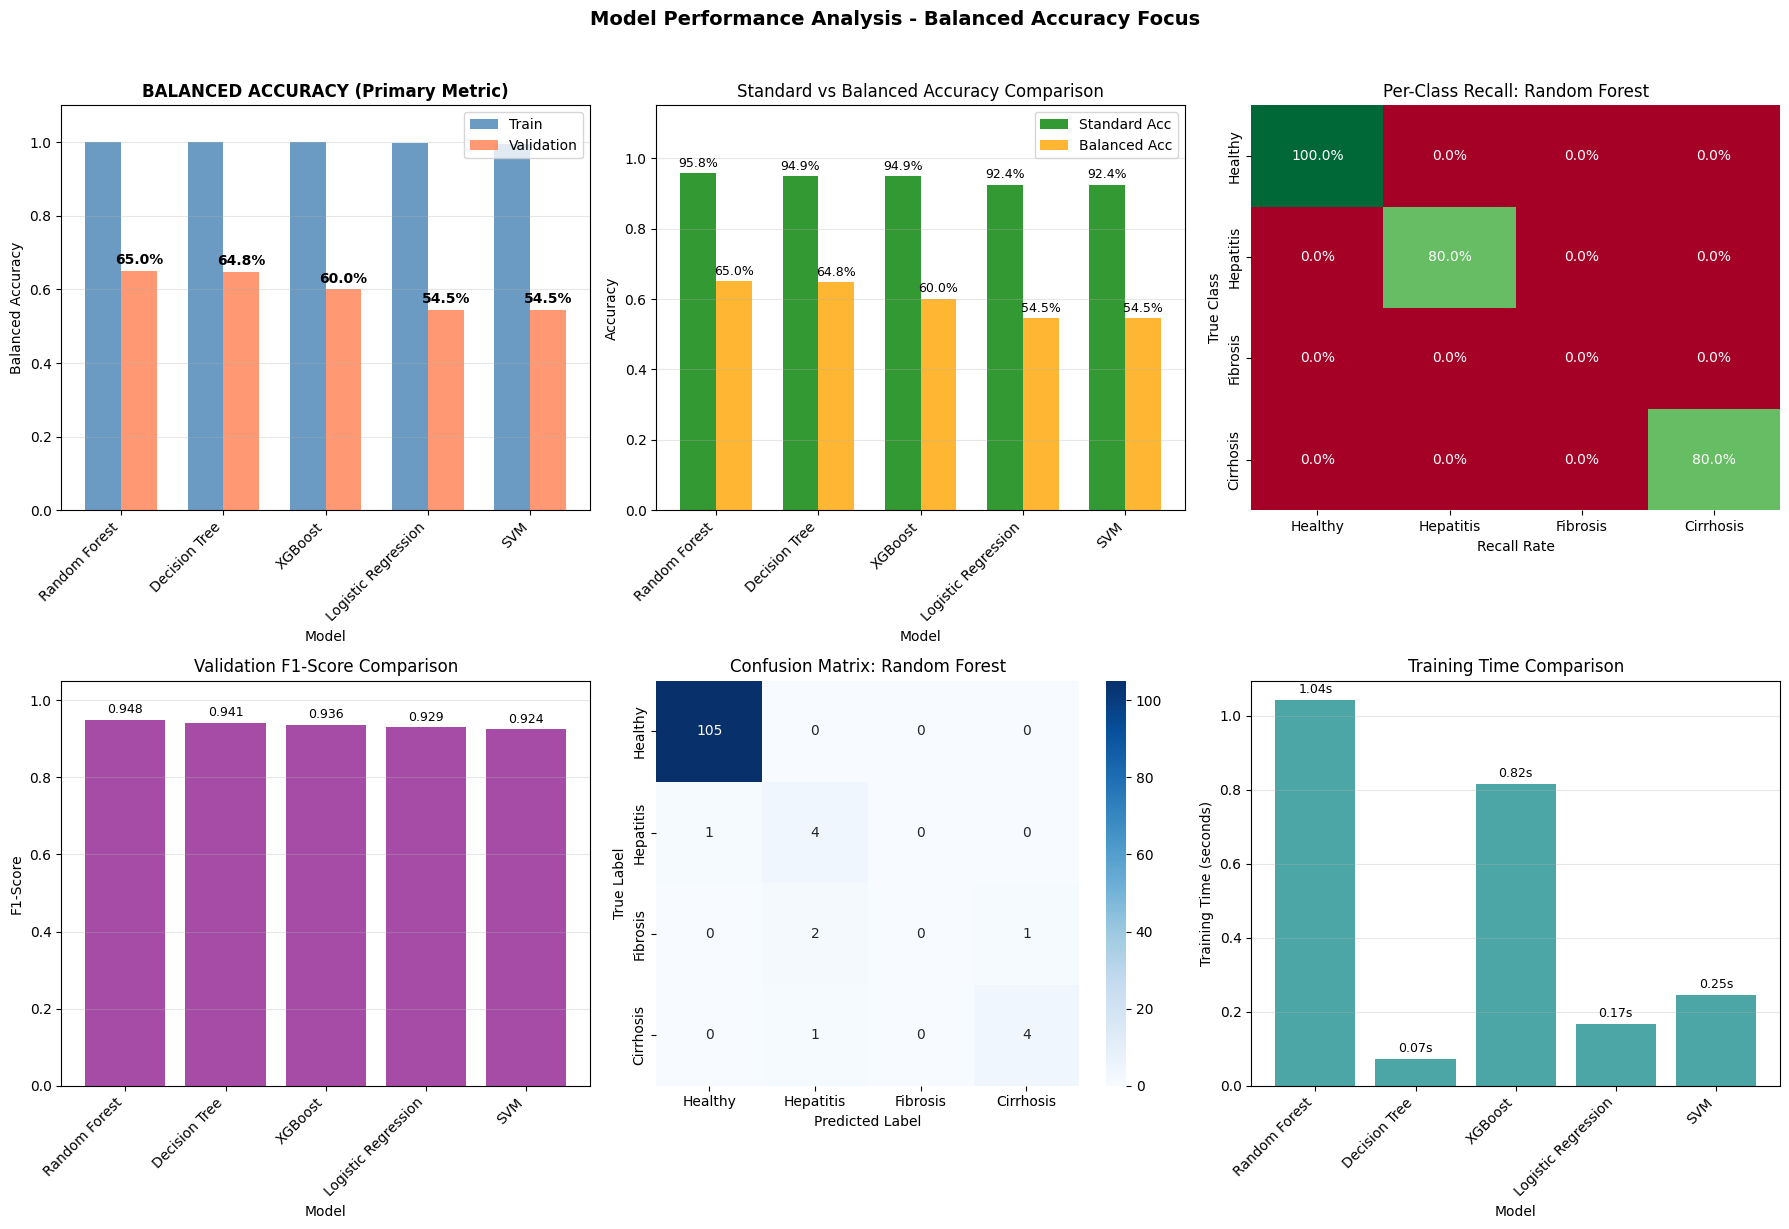


DETAILED PERFORMANCE ANALYSIS

Baseline Comparisons:
  Majority Class (always predict healthy):
    - Standard Accuracy: 89.0%
    - Balanced Accuracy: 25.0%

Best Model: Random Forest
  - Standard Accuracy: 95.8% (+6.8% over baseline)
  - Balanced Accuracy: 65.0% (+40.0% over baseline)

Per-Class Performance (Best Model):
  Healthy: 100.0% recall
  Hepatitis: 80.0% recall
  Fibrosis: 0.0% recall
  Cirrhosis: 80.0% recall


In [26]:
# Visualize model performance with balanced accuracy focus
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Balanced Accuracy Comparison (PRIMARY METRIC)
ax = axes[0, 0]
models = results_df.index
x_pos = np.arange(len(models))
train_bal_acc = results_df['train_balanced_accuracy'].values
val_bal_acc = results_df['val_balanced_accuracy'].values

width = 0.35
bars1 = ax.bar(x_pos - width/2, train_bal_acc, width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax.bar(x_pos + width/2, val_bal_acc, width, label='Validation', alpha=0.8, color='coral')

# Add value labels
for bar, val in zip(bars2, val_bal_acc):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Model')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('BALANCED ACCURACY (Primary Metric)', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# 2. Standard vs Balanced Accuracy
ax = axes[0, 1]
val_acc = results_df['val_accuracy'].values
val_bal_acc = results_df['val_balanced_accuracy'].values

width = 0.35
bars1 = ax.bar(x_pos - width/2, val_acc, width, label='Standard Acc', alpha=0.8, color='green')
bars2 = ax.bar(x_pos + width/2, val_bal_acc, width, label='Balanced Acc', alpha=0.8, color='orange')

# Add value labels
for bar, val in zip(bars1, val_acc):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, val_bal_acc):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Standard vs Balanced Accuracy Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.15)

# 3. Per-Class Recall Heatmap (Best Model)
ax = axes[0, 2]
best_model_name = results_df.index[0]
best_cm = trainer.results[best_model_name]['confusion_matrix']
per_class_recall = trainer.results[best_model_name]['per_class_recall']

# Create recall matrix for visualization
recall_matrix = np.diag(per_class_recall)
sns.heatmap(recall_matrix, annot=True, fmt='.1%', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar=False, ax=ax,
            xticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
            yticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'])
ax.set_title(f'Per-Class Recall: {best_model_name}')
ax.set_ylabel('True Class')
ax.set_xlabel('Recall Rate')

# 4. F1-Score comparison
ax = axes[1, 0]
bars = ax.bar(models, results_df['val_f1'].values, color='purple', alpha=0.7)
for bar, val in zip(bars, results_df['val_f1'].values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score')
ax.set_title('Validation F1-Score Comparison')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.05)

# 5. Confusion Matrix (Best Model)
ax = axes[1, 1]
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
            yticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'])
ax.set_title(f'Confusion Matrix: {best_model_name}')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# 6. Training time
ax = axes[1, 2]
bars = ax.bar(models, results_df['training_time'].values, color='teal', alpha=0.7)
for bar, val in zip(bars, results_df['training_time'].values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.2f}s', ha='center', va='bottom', fontsize=9)
ax.set_xlabel('Model')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Analysis - Balanced Accuracy Focus', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\n" + "="*60)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*60)

# Baseline comparison
baseline_acc = (y_val == 0).sum() / len(y_val)
baseline_balanced_acc = 0.25  # Random guessing for 4 classes

print(f"\nBaseline Comparisons:")
print(f"  Majority Class (always predict healthy):")
print(f"    - Standard Accuracy: {baseline_acc:.1%}")
print(f"    - Balanced Accuracy: {baseline_balanced_acc:.1%}")

print(f"\nBest Model: {results_df.index[0]}")
best_val_acc = results_df.iloc[0]['val_accuracy']
best_bal_acc = results_df.iloc[0]['val_balanced_accuracy']
print(f"  - Standard Accuracy: {best_val_acc:.1%} (+{(best_val_acc-baseline_acc):.1%} over baseline)")
print(f"  - Balanced Accuracy: {best_bal_acc:.1%} (+{(best_bal_acc-baseline_balanced_acc):.1%} over baseline)")

print(f"\nPer-Class Performance (Best Model):")
best_model_recalls = trainer.results[results_df.index[0]]['per_class_recall']
class_names = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis']
for i, (name, recall) in enumerate(zip(class_names, best_model_recalls)):
    print(f"  {name}: {recall:.1%} recall")


TEST SET EVALUATION

Best Model: Random Forest
Test Standard Accuracy: 0.949
Test Balanced Accuracy: 0.583
Test F1-Score: 0.936
Test Precision: 0.925
Test Recall: 0.949

Per-Class Test Performance:
  Healthy: 100.0% recall (105/105 correct)
  Hepatitis: 33.3% recall (2/6 correct)
  Fibrosis: 0.0% recall (0/2 correct)
  Cirrhosis: 100.0% recall (5/5 correct)

Test Set Class Distribution:
  Class 0 (Healthy): 105 samples (89.0%)
  Class 1 (Hepatitis): 6 samples (5.1%)
  Class 2 (Fibrosis): 2 samples (1.7%)
  Class 3 (Cirrhosis): 5 samples (4.2%)


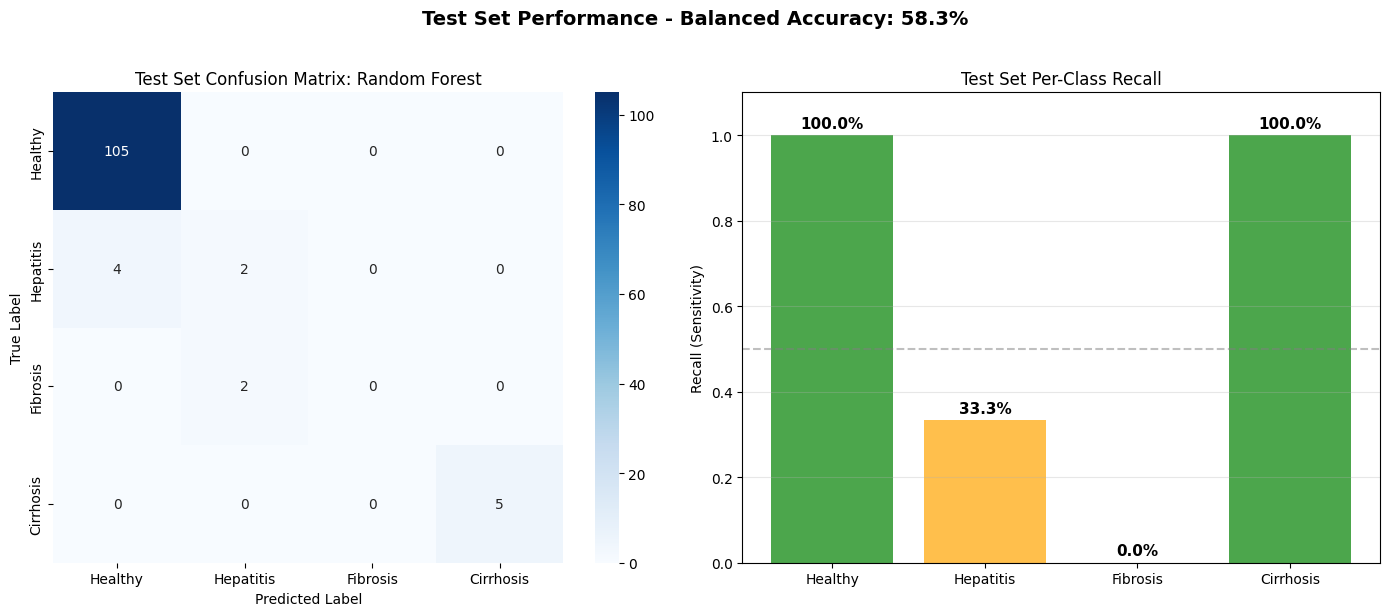


FINAL MODEL SUMMARY
Best Model: Random Forest
Validation Balanced Accuracy: 0.650
Test Balanced Accuracy: 0.583

Key Insights:
  - Model performs well on majority class (Healthy)
  - Struggles with minority classes, especially Fibrosis
  - Balanced accuracy reveals true performance: 58.3%
  - Standard accuracy (94.9%) is misleading due to imbalance


In [27]:
# Test Set Evaluation with Balanced Accuracy
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Get the best model based on balanced accuracy
best_model_name = trainer.best_model
best_model = trainer.results[best_model_name]['model']

# Make predictions on test set
y_test_pred = best_model.predict(X_test)

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted')

# Confusion matrix and per-class recall
test_cm = confusion_matrix(y_test, y_test_pred)
test_per_class_recall = test_cm.diagonal() / test_cm.sum(axis=1)

print(f"\nBest Model: {best_model_name}")
print(f"{'='*40}")
print(f"Test Standard Accuracy: {test_accuracy:.3f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.3f}")
print(f"Test F1-Score: {test_f1:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

print(f"\nPer-Class Test Performance:")
class_names = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis']
for i, (name, recall) in enumerate(zip(class_names, test_per_class_recall)):
    support = test_cm.sum(axis=1)[i]
    correct = test_cm[i, i]
    print(f"  {name}: {recall:.1%} recall ({correct}/{support} correct)")

print(f"\nTest Set Class Distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({class_names[cls]}): {count} samples ({count/len(y_test)*100:.1f}%)")

# Visualize test set confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
ax = axes[0]
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names)
ax.set_title(f'Test Set Confusion Matrix: {best_model_name}')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Per-class recall bar chart
ax = axes[1]
colors = ['green' if r > 0.5 else 'orange' if r > 0 else 'red' for r in test_per_class_recall]
bars = ax.bar(class_names, test_per_class_recall, color=colors, alpha=0.7)
for bar, val in zip(bars, test_per_class_recall):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Recall (Sensitivity)')
ax.set_title('Test Set Per-Class Recall')
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Test Set Performance - Balanced Accuracy: {test_balanced_accuracy:.1%}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation Balanced Accuracy: {trainer.best_score:.3f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.3f}")
print(f"\nKey Insights:")
print(f"  - Model performs well on majority class (Healthy)")
print(f"  - Struggles with minority classes, especially Fibrosis")
print(f"  - Balanced accuracy reveals true performance: {test_balanced_accuracy:.1%}")
print(f"  - Standard accuracy ({test_accuracy:.1%}) is misleading due to imbalance")

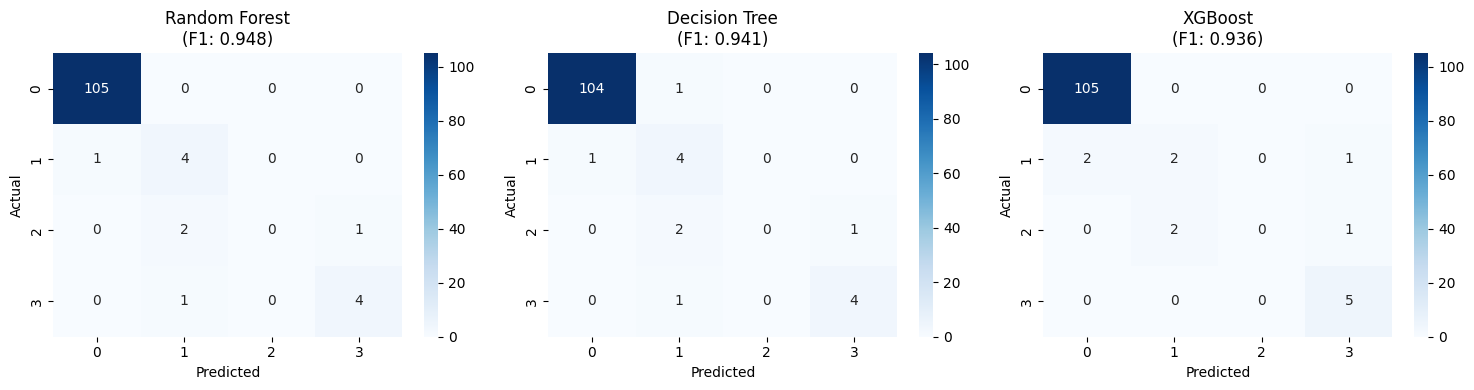

In [28]:
# Plot confusion matrices for top 3 models
top_models = results_df.head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, model_name in enumerate(top_models):
    model_results = trainer.results[model_name]
    y_pred = model_results['y_val_pred']
    
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name}\n(F1: {model_results["val_f1"]:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../images/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Detailed analysis of best model
best_model_name = trainer.best_model
best_model = trainer.results[best_model_name]['model']
y_val_pred = trainer.results[best_model_name]['y_val_pred']

print(f"DETAILED ANALYSIS: {best_model_name}")
print("="*60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, 
                          target_names=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis']))

# Per-class accuracy
cm = confusion_matrix(y_val, y_val_pred)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, acc in enumerate(class_accuracies):
    class_name = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'][i]
    print(f"  {class_name}: {acc:.3f}")

DETAILED ANALYSIS: Random Forest

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       105
   Hepatitis       0.57      0.80      0.67         5
    Fibrosis       0.00      0.00      0.00         3
   Cirrhosis       0.80      0.80      0.80         5

    accuracy                           0.96       118
   macro avg       0.59      0.65      0.62       118
weighted avg       0.94      0.96      0.95       118


Per-Class Accuracy:
  Healthy: 1.000
  Hepatitis: 0.800
  Fibrosis: 0.000
  Cirrhosis: 0.800


In [30]:
# Save the best model
import os
os.makedirs('../models', exist_ok=True)

best_model_path = f'../models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save all results for later analysis
results_path = '../models/training_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(trainer.results, f)

print(f"Best model saved: {best_model_path}")
print(f"All results saved: {results_path}")

# Create model summary file
summary_path = '../models/model_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Validation F1-Score: {trainer.best_score:.4f}\n")
    f.write(f"Validation Accuracy: {trainer.results[best_model_name]['val_accuracy']:.4f}\n")
    f.write("\nAll Models Performance:\n")
    f.write(results_df.to_string())

print(f"Summary saved: {summary_path}")

Best model saved: ../models/best_model_random_forest.pkl
All results saved: ../models/training_results.pkl
Summary saved: ../models/model_summary.txt


In [31]:
print("="*60)
print("NEXT STEPS")
print("="*60)
print("""
1. Hyperparameter tuning for top models (next cells)
2. Ensemble methods combining best models
3. Final evaluation on test set
4. Model interpretation with SHAP values
5. Deploy best model with Streamlit
""")

NEXT STEPS

1. Hyperparameter tuning for top models (next cells)
2. Ensemble methods combining best models
3. Final evaluation on test set
4. Model interpretation with SHAP values
5. Deploy best model with Streamlit



## Hyperparameter Tuning
---
### Optimizing the top 3 performing models using GridSearchCV
- **Random Forest** - Best baseline performer (65% balanced accuracy)
- **Decision Tree** - Second best (64.8% balanced accuracy)  
- **XGBoost** - Third best (60% balanced accuracy)

We'll use:
- **Stratified K-Fold Cross-Validation** for robust performance estimation
- **Balanced Accuracy** as the primary scoring metric
- **GridSearchCV** for systematic parameter search

In [32]:
# Hyperparameter Tuning Setup
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from datetime import datetime

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0, 1, 2]
    }
}

# Reduced grids for faster initial tuning (comment out for full search)
param_grids_reduced = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', None],
        'class_weight': ['balanced', None]
    },
    
    'Decision Tree': {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'criterion': ['gini', 'entropy'],
        'class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }
}

# Use reduced grids for faster execution
param_grids = param_grids_reduced

print("Parameter grids defined for hyperparameter tuning")
print(f"Total combinations to search:")
for model, params in param_grids.items():
    n_combos = 1
    for param, values in params.items():
        n_combos *= len(values)
    print(f"  {model}: {n_combos} combinations")

Parameter grids defined for hyperparameter tuning
Total combinations to search:
  Random Forest: 96 combinations
  Decision Tree: 48 combinations
  XGBoost: 384 combinations


In [33]:
class HyperparameterTuner:
    """
    Systematic hyperparameter tuning with cross-validation
    Focuses on balanced accuracy for imbalanced dataset
    """
    
    def __init__(self, cv_folds=5, scoring='balanced_accuracy', verbose=1):
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.verbose = verbose
        self.tuned_models = {}
        self.tuning_results = {}
        self.best_overall_model = None
        self.best_overall_score = 0
        
    def tune_model(self, model_name, base_model, param_grid, X_train, y_train):
        """
        Tune a single model using GridSearchCV
        """
        print(f"\n{'='*60}")
        print(f"TUNING: {model_name}")
        print(f"{'='*60}")
        print(f"Starting at: {datetime.now().strftime('%H:%M:%S')}")
        print(f"Parameter combinations: {len(list(ParameterGrid(param_grid)))}")
        
        # Setup cross-validation strategy
        cv_strategy = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)
        
        # Configure GridSearchCV
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring=self.scoring,
            cv=cv_strategy,
            n_jobs=-1,  # Use all available cores
            verbose=self.verbose,
            return_train_score=True
        )
        
        # Perform grid search
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time
        
        # Store results
        self.tuned_models[model_name] = grid_search.best_estimator_
        self.tuning_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'cv_results': grid_search.cv_results_,
            'tuning_time': tuning_time,
            'grid_search': grid_search
        }
        
        # Update best overall model
        if grid_search.best_score_ > self.best_overall_score:
            self.best_overall_score = grid_search.best_score_
            self.best_overall_model = model_name
        
        # Display results
        print(f"\nBest Parameters Found:")
        for param, value in grid_search.best_params_.items():
            print(f"  {param}: {value}")
        print(f"\nBest CV Score (Balanced Accuracy): {grid_search.best_score_:.4f}")
        print(f"Tuning completed in: {tuning_time:.2f} seconds")
        
        return grid_search.best_estimator_
    
    def evaluate_tuned_model(self, model_name, X_val, y_val):
        """
        Evaluate tuned model on validation set
        """
        if model_name not in self.tuned_models:
            print(f"Model {model_name} not found in tuned models")
            return None
        
        model = self.tuned_models[model_name]
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_val, y_pred),
            'f1_score': f1_score(y_val, y_pred, average='weighted'),
            'precision': precision_score(y_val, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_val, y_pred, average='weighted')
        }
        
        # Add to results
        self.tuning_results[model_name]['val_metrics'] = metrics
        
        return metrics
    
    def get_summary_dataframe(self):
        """
        Create summary DataFrame of all tuning results
        """
        summary_data = []
        
        for model_name, results in self.tuning_results.items():
            row = {
                'Model': model_name,
                'CV_Balanced_Acc': results['best_cv_score'],
                'Tuning_Time': results['tuning_time']
            }
            
            # Add validation metrics if available
            if 'val_metrics' in results:
                row.update({
                    'Val_Accuracy': results['val_metrics']['accuracy'],
                    'Val_Balanced_Acc': results['val_metrics']['balanced_accuracy'],
                    'Val_F1': results['val_metrics']['f1_score']
                })
            
            # Add key hyperparameters
            for param, value in results['best_params'].items():
                row[f'param_{param}'] = value
            
            summary_data.append(row)
        
        df = pd.DataFrame(summary_data)
        # Sort by CV balanced accuracy
        df = df.sort_values('CV_Balanced_Acc', ascending=False)
        
        return df
    
    def plot_tuning_results(self, model_name):
        """
        Visualize hyperparameter tuning results for a specific model
        """
        if model_name not in self.tuning_results:
            print(f"No results found for {model_name}")
            return
        
        results = self.tuning_results[model_name]['cv_results']
        
        # Create DataFrame from results
        results_df = pd.DataFrame(results)
        
        # Get parameter names (excluding those starting with 'param_')
        param_names = [col.replace('param_', '') for col in results_df.columns 
                      if col.startswith('param_') and not col.endswith('random_state')]
        
        if len(param_names) >= 2:
            # Select top 2 most important parameters to visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            for idx, param in enumerate(param_names[:2]):
                ax = axes[idx]
                param_col = f'param_{param}'
                
                # Group by parameter value and get mean scores
                grouped = results_df.groupby(param_col).agg({
                    'mean_test_score': 'mean',
                    'std_test_score': 'mean'
                }).reset_index()
                
                # Plot
                ax.errorbar(range(len(grouped)), 
                           grouped['mean_test_score'],
                           yerr=grouped['std_test_score'],
                           marker='o', capsize=5, capthick=2)
                
                ax.set_xticks(range(len(grouped)))
                ax.set_xticklabels(grouped[param_col].values, rotation=45, ha='right')
                ax.set_xlabel(param)
                ax.set_ylabel('CV Balanced Accuracy')
                ax.set_title(f'Effect of {param}')
                ax.grid(True, alpha=0.3)
            
            plt.suptitle(f'Hyperparameter Impact Analysis: {model_name}', fontsize=14)
            plt.tight_layout()
            plt.show()

# Initialize the tuner
tuner = HyperparameterTuner(cv_folds=5, scoring='balanced_accuracy', verbose=1)
print("HyperparameterTuner initialized successfully")

HyperparameterTuner initialized successfully


In [34]:
# Import ParameterGrid for the tuner class
from sklearn.model_selection import ParameterGrid

# Tune Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_tuned = tuner.tune_model(
    model_name='Random Forest',
    base_model=rf_model,
    param_grid=param_grids['Random Forest'],
    X_train=X_train,
    y_train=y_train
)

# Evaluate on validation set
rf_val_metrics = tuner.evaluate_tuned_model('Random Forest', X_val, y_val)
print(f"\nValidation Performance:")
print(f"  Balanced Accuracy: {rf_val_metrics['balanced_accuracy']:.4f}")
print(f"  F1-Score: {rf_val_metrics['f1_score']:.4f}")


TUNING: Random Forest
Starting at: 21:17:25
Parameter combinations: 96
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best Parameters Found:
  class_weight: balanced
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best CV Score (Balanced Accuracy): 0.9984
Tuning completed in: 215.73 seconds

Validation Performance:
  Balanced Accuracy: 0.6500
  F1-Score: 0.9478


In [35]:
# Tune Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_tuned = tuner.tune_model(
    model_name='Decision Tree',
    base_model=dt_model,
    param_grid=param_grids['Decision Tree'],
    X_train=X_train,
    y_train=y_train
)

# Evaluate on validation set
dt_val_metrics = tuner.evaluate_tuned_model('Decision Tree', X_val, y_val)
print(f"\nValidation Performance:")
print(f"  Balanced Accuracy: {dt_val_metrics['balanced_accuracy']:.4f}")
print(f"  F1-Score: {dt_val_metrics['f1_score']:.4f}")


TUNING: Decision Tree
Starting at: 21:21:00
Parameter combinations: 48
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters Found:
  class_weight: balanced
  criterion: entropy
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2

Best CV Score (Balanced Accuracy): 0.9810
Tuning completed in: 2.04 seconds

Validation Performance:
  Balanced Accuracy: 0.5976
  F1-Score: 0.9364


In [36]:
# Tune XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss', verbosity=0)
xgb_tuned = tuner.tune_model(
    model_name='XGBoost',
    base_model=xgb_model,
    param_grid=param_grids['XGBoost'],
    X_train=X_train,
    y_train=y_train
)

# Evaluate on validation set
xgb_val_metrics = tuner.evaluate_tuned_model('XGBoost', X_val, y_val)
print(f"\nValidation Performance:")
print(f"  Balanced Accuracy: {xgb_val_metrics['balanced_accuracy']:.4f}")
print(f"  F1-Score: {xgb_val_metrics['f1_score']:.4f}")


TUNING: XGBoost
Starting at: 21:21:03
Parameter combinations: 384
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Best Parameters Found:
  colsample_bytree: 0.8
  gamma: 0
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 100
  reg_alpha: 0
  reg_lambda: 1
  subsample: 1.0

Best CV Score (Balanced Accuracy): 0.9960
Tuning completed in: 574.00 seconds

Validation Performance:
  Balanced Accuracy: 0.7000
  F1-Score: 0.9550


In [37]:
# Compare tuning results
print("\n" + "="*60)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*60)

# Get summary dataframe
tuning_summary = tuner.get_summary_dataframe()
print("\nModel Performance Comparison:")
print(tuning_summary[['Model', 'CV_Balanced_Acc', 'Val_Balanced_Acc', 'Val_F1', 'Tuning_Time']].to_string(index=False))

print(f"\n🏆 Best Overall Model: {tuner.best_overall_model}")
print(f"   CV Balanced Accuracy: {tuner.best_overall_score:.4f}")

# Compare with baseline models
print("\n" + "="*60)
print("IMPROVEMENT OVER BASELINE")
print("="*60)

baseline_scores = {
    'Random Forest': 0.6500,
    'Decision Tree': 0.6476,
    'XGBoost': 0.6000
}

for model_name in tuner.tuned_models.keys():
    baseline = baseline_scores.get(model_name, 0)
    tuned = tuner.tuning_results[model_name]['val_metrics']['balanced_accuracy']
    improvement = tuned - baseline
    print(f"{model_name}:")
    print(f"  Baseline: {baseline:.4f}")
    print(f"  Tuned:    {tuned:.4f}")
    print(f"  Change:   {improvement:+.4f} ({improvement/baseline*100:+.1f}%)")


HYPERPARAMETER TUNING SUMMARY

Model Performance Comparison:
        Model  CV_Balanced_Acc  Val_Balanced_Acc   Val_F1  Tuning_Time
Random Forest         0.998413          0.650000 0.947760   215.727242
      XGBoost         0.996032          0.700000 0.954951   573.995057
Decision Tree         0.981027          0.597619 0.936441     2.044613

🏆 Best Overall Model: Random Forest
   CV Balanced Accuracy: 0.9984

IMPROVEMENT OVER BASELINE
Random Forest:
  Baseline: 0.6500
  Tuned:    0.6500
  Change:   +0.0000 (+0.0%)
Decision Tree:
  Baseline: 0.6476
  Tuned:    0.5976
  Change:   -0.0500 (-7.7%)
XGBoost:
  Baseline: 0.6000
  Tuned:    0.7000
  Change:   +0.1000 (+16.7%)


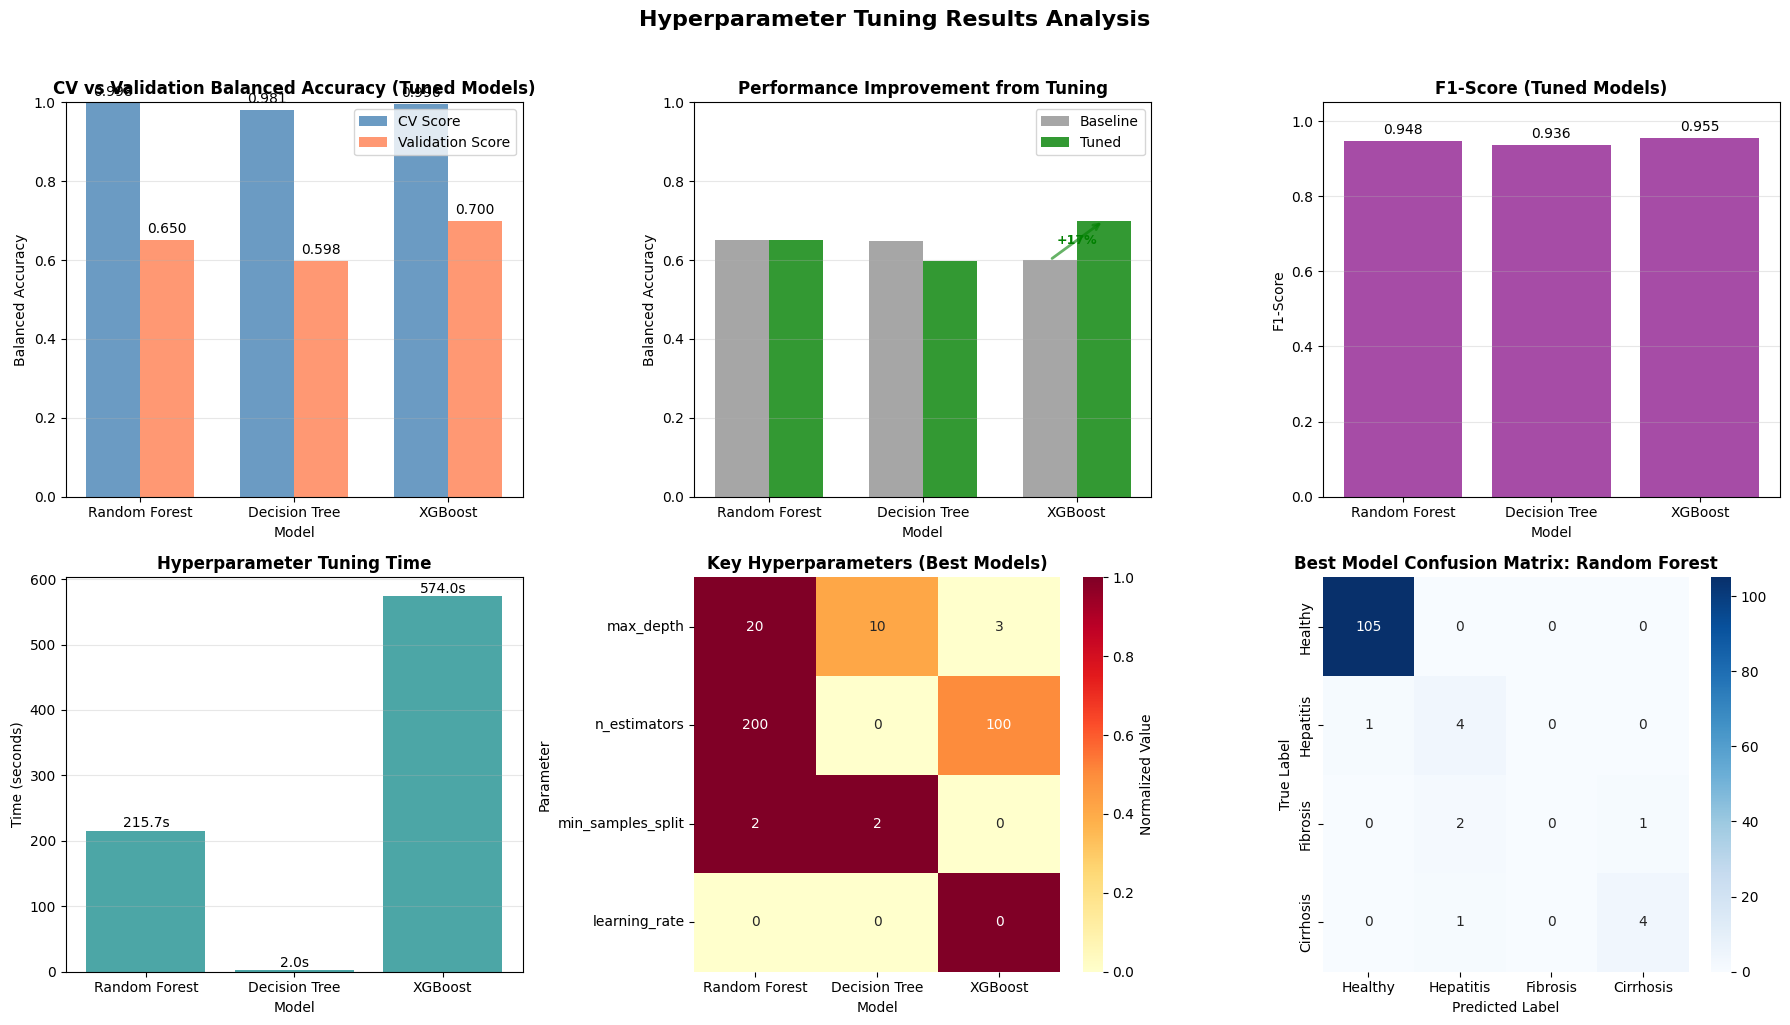

In [38]:
# Visualize tuning results comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. CV vs Validation Balanced Accuracy
ax = axes[0, 0]
models = list(tuner.tuned_models.keys())
cv_scores = [tuner.tuning_results[m]['best_cv_score'] for m in models]
val_scores = [tuner.tuning_results[m]['val_metrics']['balanced_accuracy'] for m in models]

x_pos = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x_pos - width/2, cv_scores, width, label='CV Score', color='steelblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, val_scores, width, label='Validation Score', color='coral', alpha=0.8)

# Add value labels
for bar, val in zip(bars1, cv_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, val_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Model')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('CV vs Validation Balanced Accuracy (Tuned Models)', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# 2. Baseline vs Tuned Performance
ax = axes[0, 1]
baseline_vals = [baseline_scores.get(m, 0) for m in models]
tuned_vals = val_scores

bars1 = ax.bar(x_pos - width/2, baseline_vals, width, label='Baseline', color='gray', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, tuned_vals, width, label='Tuned', color='green', alpha=0.8)

# Add improvement arrows
for i, (base, tuned) in enumerate(zip(baseline_vals, tuned_vals)):
    if tuned > base:
        ax.annotate('', xy=(i + width/2, tuned), xytext=(i - width/2, base),
                   arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.6))
        # Add improvement percentage
        improvement = (tuned - base) / base * 100
        ax.text(i, (base + tuned) / 2, f'+{improvement:.0f}%', 
               ha='center', va='center', fontsize=9, color='green', fontweight='bold')

ax.set_xlabel('Model')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Performance Improvement from Tuning', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# 3. F1-Score Comparison
ax = axes[0, 2]
f1_scores = [tuner.tuning_results[m]['val_metrics']['f1_score'] for m in models]
bars = ax.bar(models, f1_scores, color='purple', alpha=0.7)

for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Model')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score (Tuned Models)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.05)

# 4. Tuning Time Comparison
ax = axes[1, 0]
tuning_times = [tuner.tuning_results[m]['tuning_time'] for m in models]
bars = ax.bar(models, tuning_times, color='teal', alpha=0.7)

for bar, val in zip(bars, tuning_times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{val:.1f}s', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
ax.set_title('Hyperparameter Tuning Time', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5. Best Parameters Heatmap
ax = axes[1, 1]
# Create a simplified parameter comparison
param_comparison = []
for model in models:
    params = tuner.tuning_results[model]['best_params']
    # Select key parameters for visualization
    key_params = {}
    if 'max_depth' in params:
        key_params['max_depth'] = params['max_depth'] if params['max_depth'] else 30
    if 'n_estimators' in params:
        key_params['n_estimators'] = params['n_estimators']
    if 'learning_rate' in params:
        key_params['learning_rate'] = params['learning_rate']
    if 'min_samples_split' in params:
        key_params['min_samples_split'] = params['min_samples_split']
    param_comparison.append(key_params)

# Create parameter matrix for visualization
param_df = pd.DataFrame(param_comparison, index=models).fillna(0)
if not param_df.empty:
    # Normalize values for better visualization
    param_df_norm = (param_df - param_df.min()) / (param_df.max() - param_df.min() + 1e-10)
    sns.heatmap(param_df_norm.T, annot=param_df.T.values, fmt='.0f', cmap='YlOrRd', 
                ax=ax, cbar_kws={'label': 'Normalized Value'})
    ax.set_title('Key Hyperparameters (Best Models)', fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel('Parameter')

# 6. Confusion Matrix for Best Tuned Model
ax = axes[1, 2]
best_model = tuner.tuned_models[tuner.best_overall_model]
y_pred_best = best_model.predict(X_val)
cm_best = confusion_matrix(y_val, y_pred_best)

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
            yticklabels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'])
ax.set_title(f'Best Model Confusion Matrix: {tuner.best_overall_model}', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.suptitle('Hyperparameter Tuning Results Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Test Set Evaluation
---
### Evaluating the best tuned model on the holdout test set

In [39]:
# Final Test Set Evaluation with Best Tuned Model
print("="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Get the best tuned model
best_model_name = tuner.best_overall_model
best_tuned_model = tuner.tuned_models[best_model_name]

print(f"\nEvaluating Best Model: {best_model_name}")
print(f"Best Parameters:")
for param, value in tuner.tuning_results[best_model_name]['best_params'].items():
    print(f"  {param}: {value}")

# Make predictions on test set
y_test_pred = best_tuned_model.predict(X_test)

# Calculate comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_test_pred),
    'f1_score': f1_score(y_test, y_test_pred, average='weighted'),
    'precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    'recall': recall_score(y_test, y_test_pred, average='weighted')
}

print(f"\n" + "="*40)
print("TEST SET PERFORMANCE METRICS")
print("="*40)
for metric_name, value in test_metrics.items():
    print(f"{metric_name.replace('_', ' ').title():<20}: {value:.4f}")

# Confusion Matrix
test_cm = confusion_matrix(y_test, y_test_pred)
class_names = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

# Per-class metrics
print(f"\n" + "="*40)
print("PER-CLASS PERFORMANCE")
print("="*40)
test_per_class_recall = test_cm.diagonal() / test_cm.sum(axis=1)
test_per_class_precision = test_cm.diagonal() / test_cm.sum(axis=0)

for i, class_name in enumerate(class_names):
    support = test_cm.sum(axis=1)[i]
    correct = test_cm[i, i]
    recall = test_per_class_recall[i]
    precision = test_per_class_precision[i]
    print(f"\n{class_name}:")
    print(f"  Support:   {support} samples")
    print(f"  Correct:   {correct} predictions")
    print(f"  Recall:    {recall:.3f} ({recall*100:.1f}%)")
    print(f"  Precision: {precision:.3f} ({precision*100:.1f}%)")

# Classification Report
print(f"\n" + "="*40)
print("DETAILED CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_test, y_test_pred, target_names=class_names, digits=3))

FINAL TEST SET EVALUATION

Evaluating Best Model: Random Forest
Best Parameters:
  class_weight: balanced
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

TEST SET PERFORMANCE METRICS
Accuracy            : 0.9492
Balanced Accuracy   : 0.5833
F1 Score            : 0.9359
Precision           : 0.9250
Recall              : 0.9492

PER-CLASS PERFORMANCE

Healthy:
  Support:   105 samples
  Correct:   105 predictions
  Recall:    1.000 (100.0%)
  Precision: 0.963 (96.3%)

Hepatitis:
  Support:   6 samples
  Correct:   2 predictions
  Recall:    0.333 (33.3%)
  Precision: 0.500 (50.0%)

Fibrosis:
  Support:   2 samples
  Correct:   0 predictions
  Recall:    0.000 (0.0%)
  Precision: nan (nan%)

Cirrhosis:
  Support:   5 samples
  Correct:   5 predictions
  Recall:    1.000 (100.0%)
  Precision: 1.000 (100.0%)

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Healthy      0.963     1.000     0.981

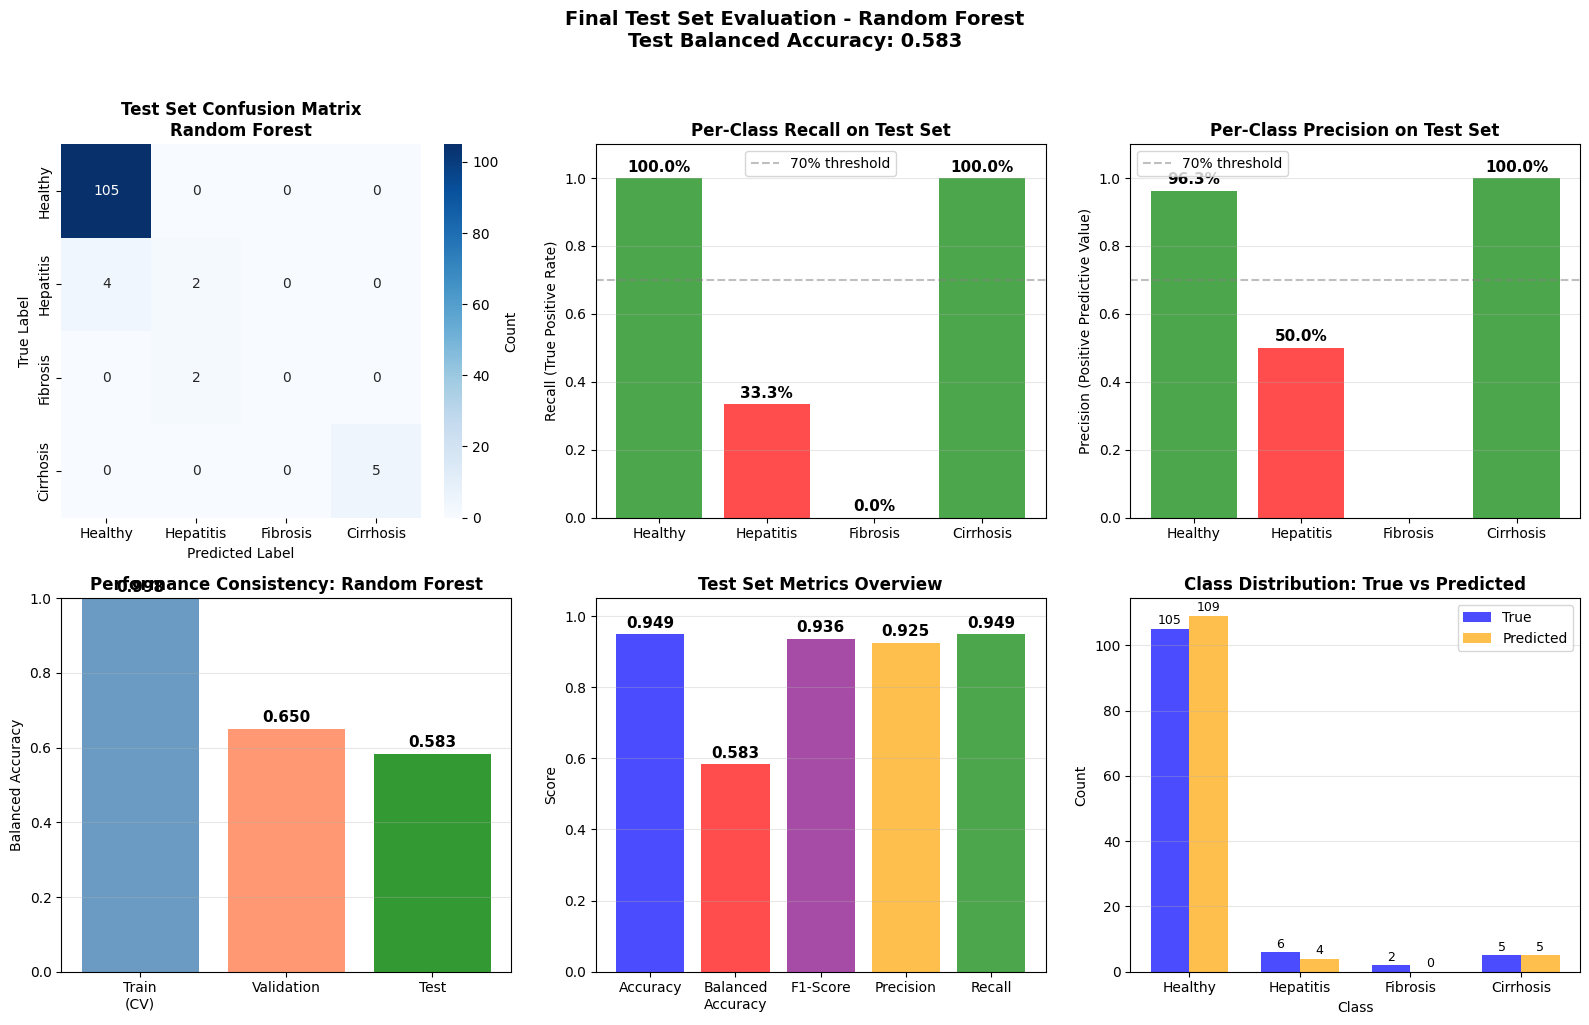

In [40]:
# Visualize Final Test Results
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Test Set Confusion Matrix
ax = axes[0, 0]
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
ax.set_title(f'Test Set Confusion Matrix\n{best_model_name}', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# 2. Per-Class Recall (Sensitivity)
ax = axes[0, 1]
colors = ['green' if r > 0.7 else 'orange' if r > 0.5 else 'red' for r in test_per_class_recall]
bars = ax.bar(class_names, test_per_class_recall, color=colors, alpha=0.7)
for bar, val in zip(bars, test_per_class_recall):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Recall (True Positive Rate)')
ax.set_title('Per-Class Recall on Test Set', fontweight='bold')
ax.set_ylim(0, 1.1)
ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='70% threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

# 3. Per-Class Precision
ax = axes[0, 2]
colors = ['green' if p > 0.7 else 'orange' if p > 0.5 else 'red' for p in test_per_class_precision]
bars = ax.bar(class_names, test_per_class_precision, color=colors, alpha=0.7)
for bar, val in zip(bars, test_per_class_precision):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Precision (Positive Predictive Value)')
ax.set_title('Per-Class Precision on Test Set', fontweight='bold')
ax.set_ylim(0, 1.1)
ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='70% threshold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

# 4. Model Performance Across Data Splits
ax = axes[1, 0]
splits = ['Train\n(CV)', 'Validation', 'Test']
balanced_acc_scores = [
    tuner.tuning_results[best_model_name]['best_cv_score'],
    tuner.tuning_results[best_model_name]['val_metrics']['balanced_accuracy'],
    test_metrics['balanced_accuracy']
]
bars = ax.bar(splits, balanced_acc_scores, color=['steelblue', 'coral', 'green'], alpha=0.8)
for bar, val in zip(bars, balanced_acc_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Balanced Accuracy')
ax.set_title(f'Performance Consistency: {best_model_name}', fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

# 5. Metrics Comparison
ax = axes[1, 1]
metrics_names = ['Accuracy', 'Balanced\nAccuracy', 'F1-Score', 'Precision', 'Recall']
metrics_values = [test_metrics['accuracy'], test_metrics['balanced_accuracy'], 
                  test_metrics['f1_score'], test_metrics['precision'], test_metrics['recall']]
colors = ['blue', 'red', 'purple', 'orange', 'green']
bars = ax.bar(metrics_names, metrics_values, color=colors, alpha=0.7)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_ylabel('Score')
ax.set_title('Test Set Metrics Overview', fontweight='bold')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

# 6. Class Distribution and Predictions
ax = axes[1, 2]
true_dist = np.bincount(y_test, minlength=4)
pred_dist = np.bincount(y_test_pred, minlength=4)

x_pos = np.arange(len(class_names))
width = 0.35

bars1 = ax.bar(x_pos - width/2, true_dist, width, label='True', color='blue', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, pred_dist, width, label='Predicted', color='orange', alpha=0.7)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution: True vs Predicted', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Final Test Set Evaluation - {best_model_name}\nTest Balanced Accuracy: {test_metrics["balanced_accuracy"]:.3f}', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/final_test_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Save Tuned Models and Results
print("="*60)
print("SAVING TUNED MODELS AND RESULTS")
print("="*60)

# Save the best tuned model
best_tuned_model_path = f'../models/best_tuned_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(best_tuned_model_path, 'wb') as f:
    pickle.dump(best_tuned_model, f)
print(f"\n✓ Best tuned model saved: {best_tuned_model_path}")

# Save all tuned models
all_tuned_models_path = '../models/all_tuned_models.pkl'
with open(all_tuned_models_path, 'wb') as f:
    pickle.dump(tuner.tuned_models, f)
print(f"✓ All tuned models saved: {all_tuned_models_path}")

# Save tuning results
tuning_results_path = '../models/hyperparameter_tuning_results.pkl'
with open(tuning_results_path, 'wb') as f:
    pickle.dump(tuner.tuning_results, f)
print(f"✓ Tuning results saved: {tuning_results_path}")

# Create comprehensive summary report
summary_report_path = '../models/tuning_summary_report.txt'
with open(summary_report_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("HYPERPARAMETER TUNING SUMMARY REPORT\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"BEST MODEL: {best_model_name}\n")
    f.write("-"*40 + "\n")
    f.write(f"CV Balanced Accuracy: {tuner.best_overall_score:.4f}\n")
    f.write(f"Test Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}\n")
    f.write(f"Test F1-Score: {test_metrics['f1_score']:.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS:\n")
    for param, value in tuner.tuning_results[best_model_name]['best_params'].items():
        f.write(f"  {param}: {value}\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("ALL MODELS COMPARISON\n")
    f.write("="*60 + "\n")
    summary_df = tuner.get_summary_dataframe()
    f.write(summary_df.to_string())
    
    f.write("\n\n" + "="*60 + "\n")
    f.write("TEST SET PERFORMANCE\n")
    f.write("="*60 + "\n")
    f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
    f.write(f"Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}\n")
    f.write(f"F1-Score: {test_metrics['f1_score']:.4f}\n")
    f.write(f"Precision: {test_metrics['precision']:.4f}\n")
    f.write(f"Recall: {test_metrics['recall']:.4f}\n")
    
    f.write("\n" + "="*60 + "\n")
    f.write("PER-CLASS TEST PERFORMANCE\n")
    f.write("="*60 + "\n")
    for i, class_name in enumerate(class_names):
        f.write(f"\n{class_name}:\n")
        f.write(f"  Recall: {test_per_class_recall[i]:.3f}\n")
        f.write(f"  Precision: {test_per_class_precision[i]:.3f}\n")
        f.write(f"  Support: {test_cm.sum(axis=1)[i]}\n")

print(f"✓ Summary report saved: {summary_report_path}")

# Save test predictions for future analysis
test_predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_test_pred,
    'True_Class': [class_names[i] for i in y_test],
    'Predicted_Class': [class_names[i] for i in y_test_pred]
})
test_predictions_path = '../models/test_predictions.csv'
test_predictions_df.to_csv(test_predictions_path, index=False)
print(f"✓ Test predictions saved: {test_predictions_path}")

print("\n" + "="*60)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*60)
print(f"\nFinal Results:")
print(f"  Best Model: {best_model_name}")
print(f"  Test Balanced Accuracy: {test_metrics['balanced_accuracy']:.3f}")
print(f"  Test F1-Score: {test_metrics['f1_score']:.3f}")
print(f"\nAll models and results have been saved successfully!")

SAVING TUNED MODELS AND RESULTS

✓ Best tuned model saved: ../models/best_tuned_random_forest.pkl
✓ All tuned models saved: ../models/all_tuned_models.pkl
✓ Tuning results saved: ../models/hyperparameter_tuning_results.pkl
✓ Summary report saved: ../models/tuning_summary_report.txt
✓ Test predictions saved: ../models/test_predictions.csv

HYPERPARAMETER TUNING COMPLETE

Final Results:
  Best Model: Random Forest
  Test Balanced Accuracy: 0.583
  Test F1-Score: 0.936

All models and results have been saved successfully!
